# Dataset Download

In [1]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle

In [45]:
#Download your api kaggle.json from kaggle and upload it here
from google.colab import files
files.upload()

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [4]:
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d raddar/tuberculosis-chest-xrays-shenzhen

Dataset URL: https://www.kaggle.com/datasets/raddar/tuberculosis-chest-xrays-shenzhen
License(s): unknown
100% 3.51G/3.51G [00:34<00:00, 196MB/s]
100% 3.51G/3.51G [00:34<00:00, 111MB/s]


In [5]:
#unziping the file
from zipfile import ZipFile
file_name = '/content/tuberculosis-chest-xrays-shenzhen.zip'

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


# Libraries


In [6]:
!pip install split-folders

In [7]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, BatchNormalization, MaxPool2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import splitfolders
from glob import glob

# Preprocessing

In [8]:
datainfo = pd.read_csv('/content/shenzhen_metadata.csv')

In [9]:
datainfo.head()

,study_id,sex,age,findings
0,CHNCXR_0001_0.png,Male,45,normal
1,CHNCXR_0002_0.png,Male,63,normal
2,CHNCXR_0003_0.png,Female,48,normal
3,CHNCXR_0004_0.png,Male,58,normal
4,CHNCXR_0005_0.png,Male,28,normal


In [10]:
normal = []
positive =  []

In [11]:
def extract_target(x):
  for i in range(len(x['study_id'])):
    if x['findings'][i] == 'normal':
      normal.append(x['study_id'][i])
    else:
      positive.append(x['study_id'][i])


In [12]:
extract_target(datainfo)

In [13]:
len(normal)


326

In [14]:
len(positive)

336

# Creating Directories


In [15]:
!mkdir data

In [16]:
!mkdir data/normal
!mkdir data/positive

In [17]:
for i in range(len(normal)):
  path = '/content/images/images/' + normal[i]
  !mv $path /content/data/normal

In [18]:
for i in range(len(positive)):
  path = '/content/images/images/' + positive[i]
  !mv $path /content/data/positive

In [19]:
input_folder = "/content/data"
output = "/content/dataset" #where you want the split datasets saved. one will be created if none is set

splitfolders.ratio(input_folder, output=output, seed=42, ratio=(.8, .0, 0.2)) # ratio of split are in order of train/val/test. You can change to whatever you want. For train/val sets only, you could do .75, .25 for example.

Copying files: 662 files [00:37, 17.51 files/s]


# Data Visualization

In [20]:
tuberculosis  = glob('/content/dataset/test/positive/*.png')
normal = glob('/content/dataset/test/normal/*.png')

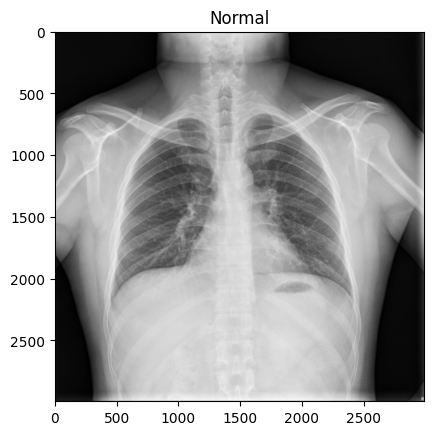

In [21]:
plt.title('Normal')
plt.imshow(image.load_img(np.random.choice(normal)))
plt.show()

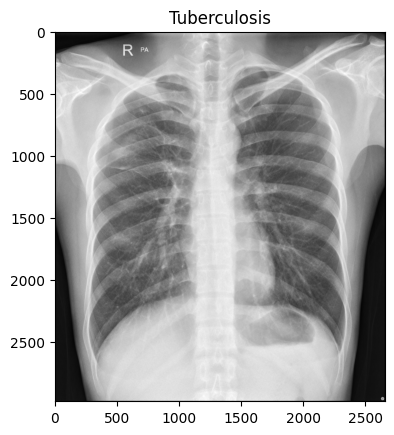

In [22]:
plt.title('Tuberculosis')
plt.imshow(image.load_img(np.random.choice(tuberculosis)))
plt.show()

# Image Processing and Data Partition into Train and Test

In [23]:
img_width = 150
img_height = 150

datagen = ImageDataGenerator(rescale=1/255.0)

In [24]:
train_data_gen = datagen.flow_from_directory(directory='/content/dataset/train',
                                             target_size = (img_width, img_height),
                                             class_mode = 'sparse')
test_data_gen = datagen.flow_from_directory(directory='/content/dataset/test',
                                            target_size = (img_width, img_height),
                                             class_mode = 'sparse',)

Found 528 images belonging to 2 classes.
Found 134 images belonging to 2 classes.


# Deep Learning Model

In [25]:
model = Sequential()

#convolution
model.add(Conv2D(32, (3,3), input_shape = (img_width, img_height, 3), activation='relu', padding='same'))
model.add(MaxPool2D(2,2))

model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(MaxPool2D(2,2))

model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(MaxPool2D(2,2))

model.add(Conv2D(192, (3,3), activation='relu', padding='same'))
model.add(MaxPool2D(2,2))

#Dense
model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))


model.add(Dense(228, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(270, activation='relu'))
model.add(Dropout(0.3))



model.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [26]:
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

In [29]:
# r = model.fit_generator(generator=train_data_gen,
#                               steps_per_epoch=len(train_data_gen),
#                               epochs=20,
#                               validation_data= test_data_gen,
#                               validation_steps = len(test_data_gen))
r = model.fit(train_data_gen, # Pass train_data_gen directly as the first argument
              steps_per_epoch=len(train_data_gen),
              epochs=20,
              validation_data=test_data_gen,
              validation_steps=len(test_data_gen))

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 79s 4s/step - accuracy: 0.5769 - loss: 0.6976 - val_accuracy: 0.4925 - val_loss: 0.6930
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 63s 3s/step - accuracy: 0.5373 - loss: 0.6855 - val_accuracy: 0.7313 - val_loss: 0.5655
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 76s 3s/step - accuracy: 0.7742 - loss: 0.6167 - val_accuracy: 0.8209 - val_loss: 0.5228
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.8152 - loss: 0.4965 - val_accuracy: 0.7910 - val_loss: 0.4838
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - accuracy: 0.8290 - loss: 0.4332 - val_accuracy: 0.7985 - val_loss: 0.5058
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 53s 3s/step - accuracy: 0.8345 - loss: 0.4737 - val_accuracy: 0.7910 - val_loss: 0.4741
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.8062 - loss: 0.4610 - val_accuracy: 0.7985 - val_loss: 0.5531
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 52s 3s/step - accuracy: 0.8410 - loss: 0.4358 - val_accuracy: 0.8060 - val_loss:

# Analysis/Evaluation

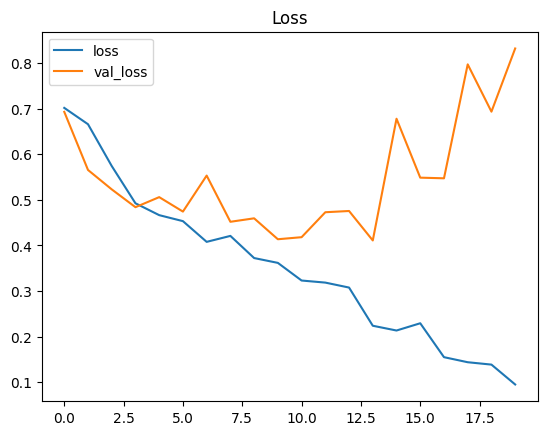

In [30]:
plt.title('Loss')
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

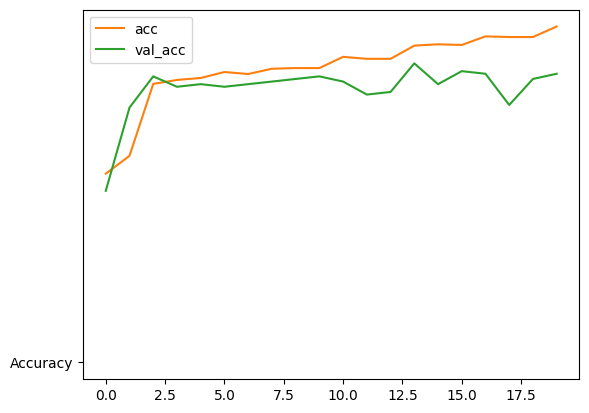

In [31]:
plt.plot('Accuracy')
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()

# Saving the Model


In [32]:
model.save('Tuberculosis.h5')

In [33]:
model = tf.keras.models.load_model("Tuberculosis.h5")
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open('Tuberculosis.tflite', 'wb').write(tflite_model)

Saved artifact at '/tmp/tmplxiae4vd'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  139863167992656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139863167992080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139863167995920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139863167993424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139863167992272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139862861378960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139862861367056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139862861378384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139862861377232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139862861373968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139862861378768

9593036

Model '/content/Tuberculosis.h5' loaded successfully.

--- Model Summary (for confirmation) ---


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 18, 18, 192)    │       221,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 9, 9, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 15552)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,990,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 228)            │        29,412 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 228)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 270)            │        61,830 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 270)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           271 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,396,923 (9.14 MB)

 Trainable params: 2,396,921 (9.14 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

-------------------------------------------


Attempting prediction for: /content/CHNCXR_0327_1.png


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step
Image: CHNCXR_0327_1.png
Raw prediction (Tuberculosis probability): [0.9858899]
Predicted: Tuberculosis (Confidence: 98.59%)


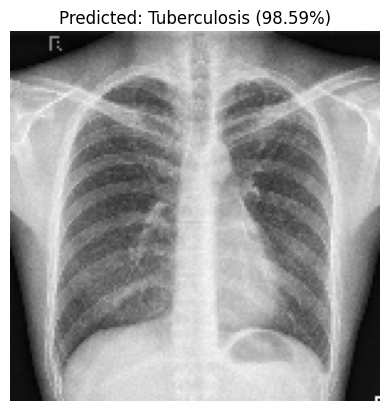

In [44]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import os

# Load the trained model (assuming 'Tuberculosis.h5' is in the specified path)
model_path = '/content/Tuberculosis.h5' # Your provided path
try:
    model = tf.keras.models.load_model(model_path)
    print(f"Model '{model_path}' loaded successfully.")
    print("\n--- Model Summary (for confirmation) ---")
    model.summary()
    print("-------------------------------------------\n")
except Exception as e:
    print(f"Error loading model: {e}")
    print(f"Please ensure '{model_path}' is in the correct path and the model was saved properly.")
    model = None # Set model to None if loading fails

def predict_image(img_path, model, target_size=(150, 150), class_names=['Normal', 'Tuberculosis']): # <<< CHANGED TARGET_SIZE
    """
    Predicts the class of a single image (Normal or Tuberculosis).

    Args:
        img_path (str): Path to the image file.
        model (tf.keras.Model): The loaded Keras model.
        target_size (tuple): The input size the model expects (width, height).
        class_names (list): List of class names corresponding to model output.

    Returns:
        tuple: (predicted_class_name, confidence, raw_prediction_output)
    """
    if model is None:
        print("Model not loaded. Cannot make prediction.")
        return None, None, None

    img = image.load_img(img_path, target_size=target_size) # Image will be resized to (150, 150)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) # Add batch dimension
    img_array = img_array / 255.0  # Normalize pixel values

    predictions = model.predict(img_array)

    # Assuming binary classification where the output is a single probability
    # for the 'Tuberculosis' class. Your last layer `dense_3` has (None, 1) output.
    tuberculosis_probability = predictions[0][0]

    if tuberculosis_probability > 0.5:
        predicted_class_name = 'Tuberculosis'
        confidence = tuberculosis_probability
    else:
        predicted_class_name = 'Normal'
        confidence = 1 - tuberculosis_probability

    print(f"Image: {os.path.basename(img_path)}")
    print(f"Raw prediction (Tuberculosis probability): {predictions[0]}")
    print(f"Predicted: {predicted_class_name} (Confidence: {confidence:.2%})")

    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class_name} ({confidence:.2%})")
    plt.axis('off')
    plt.show()

    return predicted_class_name, confidence, predictions[0]

# --- Example Usage ---
# Use the path you confirmed is working
test_image_path = '/content/CHNCXR_0327_1.png' # Your specific test image path

if os.path.exists(test_image_path):
    print(f"\nAttempting prediction for: {test_image_path}")
    predicted_class, confidence, raw_output = predict_image(test_image_path, model)
else:
    print(f"\nError: Image not found at {test_image_path}. Please double-check the path and ensure it's uploaded.")

Model '/content/Tuberculosis.h5' loaded successfully.

--- Model Summary (for confirmation) ---


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 18, 18, 192)    │       221,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 9, 9, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 15552)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,990,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 228)            │        29,412 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 228)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 270)            │        61,830 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 270)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           271 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,396,923 (9.14 MB)

 Trainable params: 2,396,921 (9.14 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

-------------------------------------------


Attempting prediction for: /content/others (49).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step
Image: others (49).jpg
Raw prediction (Tuberculosis probability): [2.9221052e-05]
Predicted: Normal (Confidence: 100.00%)


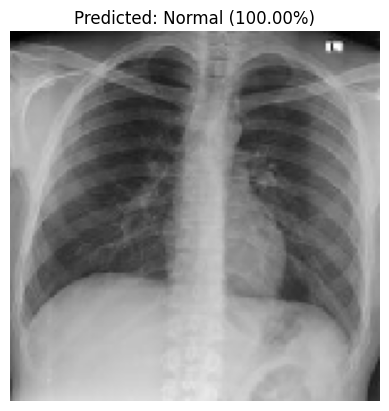

In [41]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import os

# Load the trained model (assuming 'Tuberculosis.h5' is in the specified path)
model_path = '/content/Tuberculosis.h5' # Your provided path
try:
    model = tf.keras.models.load_model(model_path)
    print(f"Model '{model_path}' loaded successfully.")
    print("\n--- Model Summary (for confirmation) ---")
    model.summary()
    print("-------------------------------------------\n")
except Exception as e:
    print(f"Error loading model: {e}")
    print(f"Please ensure '{model_path}' is in the correct path and the model was saved properly.")
    model = None # Set model to None if loading fails

def predict_image(img_path, model, target_size=(150, 150), class_names=['Normal', 'Tuberculosis']): # <<< CHANGED TARGET_SIZE
    """
    Predicts the class of a single image (Normal or Tuberculosis).

    Args:
        img_path (str): Path to the image file.
        model (tf.keras.Model): The loaded Keras model.
        target_size (tuple): The input size the model expects (width, height).
        class_names (list): List of class names corresponding to model output.

    Returns:
        tuple: (predicted_class_name, confidence, raw_prediction_output)
    """
    if model is None:
        print("Model not loaded. Cannot make prediction.")
        return None, None, None

    img = image.load_img(img_path, target_size=target_size) # Image will be resized to (150, 150)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) # Add batch dimension
    img_array = img_array / 255.0  # Normalize pixel values

    predictions = model.predict(img_array)

    # Assuming binary classification where the output is a single probability
    # for the 'Tuberculosis' class. Your last layer `dense_3` has (None, 1) output.
    tuberculosis_probability = predictions[0][0]

    if tuberculosis_probability > 0.5:
        predicted_class_name = 'Tuberculosis'
        confidence = tuberculosis_probability
    else:
        predicted_class_name = 'Normal'
        confidence = 1 - tuberculosis_probability

    print(f"Image: {os.path.basename(img_path)}")
    print(f"Raw prediction (Tuberculosis probability): {predictions[0]}")
    print(f"Predicted: {predicted_class_name} (Confidence: {confidence:.2%})")

    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class_name} ({confidence:.2%})")
    plt.axis('off')
    plt.show()

    return predicted_class_name, confidence, predictions[0]

# --- Example Usage ---
# Use the path you confirmed is working
test_image_path = '/content/others (49).jpg' # Your specific test image path

if os.path.exists(test_image_path):
    print(f"\nAttempting prediction for: {test_image_path}")
    predicted_class, confidence, raw_output = predict_image(test_image_path, model)
else:
    print(f"\nError: Image not found at {test_image_path}. Please double-check the path and ensure it's uploaded.")